In [1]:
import pandas as pd
import numpy as np
from functools import lru_cache
from numba import njit, prange
import itertools
from scipy import stats
#import owlready2
from collections import Counter
import anndata as ad

## getting all possible types of values

In [3]:
#ls ../../../data

cellxgene/  data.lndb


In [2]:
# !lamin login jkobject
# !lamin init --storage ../../../data2 --schema bionty
# !lamin load laminlabs/cellxgene-census

✅ saved: User(uid='a3keNAVX', handle='jkobject', updated_at=2023-11-17 09:29:12 UTC)
✅ saved: Storage(uid='sFdlllj3', root='/home/ml4ig1/Documents code/data2', type='local', updated_at=2023-11-17 09:29:12 UTC, created_by_id=1)
💡 loaded instance: jkobject/data2
💡 did not register local instance on hub


In [2]:
import lamindb as ln
import lnschema_bionty as lb

💡 lamindb instance: jkobject/scprint


In [2]:
lb.settings.organism = "human"
#ln.settings.verbosity = "hint"

In [5]:
# ln.track()

💡 Attaching notebook metadata


💡 notebook imports: anndata==0.10.3 cellxgene-census==1.7.0 decoupler lamindb==0.61.0 lnschema_bionty==0.35.0 numba==0.56.4 numpy==1.23.5 omnipath pandas==2.1.3 scipy==1.11.3 tiledbsoma==1.4.4


UpdateNbWithNonInteractiveEditorError: 
(1) save your notebook!
(2) attach metadata to the notebook by running the CLI:
lamin track /home/ml4ig1/Documents code/scPRINT/notebooks/assessments/work_on_dataloader_onto part 2.ipynb
(3) reload or re-open your notebook

In [121]:
bt.display_available_sources()

,source,organism,version,url,md5,source_name,source_website
entity,,,,,,,
Organism,ensembl,vertebrates,release-110,https://ftp.ensembl.org/pub/release-110/specie...,f3faf95648d3a2b50fd3625456739706,Ensembl,https://www.ensembl.org
Organism,ensembl,vertebrates,release-109,https://ftp.ensembl.org/pub/release-109/specie...,7595bb989f5fec07eaca5e2138f67bd4,Ensembl,https://www.ensembl.org
Organism,ensembl,vertebrates,release-108,https://ftp.ensembl.org/pub/release-108/specie...,d97c1ee302e4072f5f5c7850eff0b642,Ensembl,https://www.ensembl.org
Organism,ensembl,bacteria,release-57,https://ftp.ensemblgenomes.ebi.ac.uk/pub/bacte...,ee28510ed5586ea7ab4495717c96efc8,Ensembl,https://www.ensembl.org
Organism,ensembl,fungi,release-57,http://ftp.ensemblgenomes.org/pub/fungi/releas...,dbcde58f4396ab8b2480f7fe9f83df8a,Ensembl,https://www.ensembl.org
Organism,ensembl,metazoa,release-57,http://ftp.ensemblgenomes.org/pub/metazoa/rele...,424636a574fec078a61cbdddb05f9132,Ensembl,https://www.ensembl.org
Organism,ensembl,plants,release-57,https://ftp.ensemblgenomes.ebi.ac.uk/pub/plant...,eadaa1f3e527e4c3940c90c7fa5c8bf4,Ensembl,https://www.ensembl.org
Organism,ncbitaxon,all,2023-06-20,s3://bionty-assets/df_all__ncbitaxon__2023-06-...,00d97ba65627f1cd65636d2df22ea76c,NCBItaxon Ontology,https://github.com/obophenotype/ncbitaxon
Gene,ensembl,human,release-110,s3://bionty-assets/df_human__ensembl__release-...,832f3947e83664588d419608a469b528,Ensembl,https://www.ensembl.org


In [45]:
# Celltype
names = bt.CellType().filter().df().index
records = lb.CellType.from_values(names, field=lb.CellType.ontology_id)
ln.save(records)
lb.CellType(name="unknown", ontology_id="unknown").save()
# Organism
# names = bt.Organism().filter().df().index
names = ['NCBITaxon:10090', 'NCBITaxon:9606']
records = lb.Organism.from_values(names, field=lb.Organism.ontology_id)
ln.save(records)
lb.Organism(name="unknown", ontology_id="unknown").save()
# Phenotype
#name = bt.Phenotype().filter().df().index
name = df['sex_ontology_term_id'].unique()
records = lb.Phenotype.from_values(name, field=lb.Phenotype.ontology_id)
ln.save(records)
lb.Phenotype(name="unknown", ontology_id="unknown").save()
# ethnicity
names = bt.Ethnicity().filter().df().index
records = lb.Ethnicity.from_values(names, field=lb.Ethnicity.ontology_id)
ln.save(records)
lb.Ethnicity(name="unknown", ontology_id="unknown").save() #multi ethnic will have to get renamed
# ExperimentalFactor
names = df2['assay_ontology_term_id'].unique()
records = lb.ExperimentalFactor.from_values(names, field=lb.ExperimentalFactor.ontology_id)
ln.save(records)
lb.ExperimentalFactor(name="SMART-Seq v4", ontology_id="EFO:0700016").save()
lb.ExperimentalFactor(name="unknown", ontology_id="unknown").save()
lookup = lb.ExperimentalFactor.lookup()
lookup.smart_seq_v4.parents.add(lookup.smart_like)
# Tissue
#names = bt.Tissue().filter().df().index
names= df['tissue_ontology_term_id'].unique()
records = lb.Tissue.from_values(names, field=lb.Tissue.ontology_id)
ln.save(records)
lb.Tissue(name="unknown", ontology_id="unknown").save()
# DevelopmentalStage
bionty_df = bt.DevelopmentalStage().filter().df()
records = lb.DevelopmentalStage.from_values(bionty_df.index, field=lb.DevelopmentalStage.ontology_id, organism="mouse")
ln.save(records)
lb.DevelopmentalStage(name="unknown", ontology_id="unknown").save()
# Disease
# values = bt.Disease().filter().df().index
values = df['disease_ontology_term_id'].unique()
records = lb.Disease.from_values(values, field=lb.Disease.ontology_id)
ln.save(records)
lb.Disease(name="normal", ontology_id="PATO:0000461").save()
lb.Disease(name="unknown", ontology_id="unknown").save()
# genes
bionty_df = bt.Gene().filter().df()
records = lb.Gene.from_values(bionty_df.index, field=lb.Gene.ontology_id)
ln.save(records)

✅ loaded 37 CellType records matching ontology_id: 'CL:0000057', 'CL:0000071', 'CL:0000077', 'CL:0000158', 'CL:0000186', 'CL:0000192', 'CL:0000235', 'CL:0000236', 'CL:0000359', 'CL:0000451', 'CL:0000624', 'CL:0000625', 'CL:0000646', 'CL:0000669', 'CL:0000767', 'CL:0000775', 'CL:0000784', 'CL:0000786', 'CL:0000814', 'CL:0000860', ...
✅ created 2825 CellType records from Bionty matching ontology_id: 'CL:0000000', 'CL:0000001', 'CL:0000002', 'CL:0000003', 'CL:0000004', 'CL:0000005', 'CL:0000006', 'CL:0000007', 'CL:0000008', 'CL:0000009', 'CL:0000010', 'CL:0000011', 'CL:0000012', 'CL:0000013', 'CL:0000014', 'CL:0000015', 'CL:0000016', 'CL:0000017', 'CL:0000018', 'CL:0000019', ...
✅ created 2825 CellType records from Bionty matching ontology_id: 'CL:0000000', 'CL:0000001', 'CL:0000002', 'CL:0000003', 'CL:0000004', 'CL:0000005', 'CL:0000006', 'CL:0000007', 'CL:0000008', 'CL:0000009', 'CL:0000010', 'CL:0000011', 'CL:0000012', 'CL:0000013', 'CL:0000014', 'CL:0000015', 'CL:0000016', 'CL:0000017

In [164]:
lb.DevelopmentalStage.ontology_id

FieldAttr(DevelopmentalStage.ontology_id)

In [299]:
tissdf = lb.Tissue.filter().df(include=["parents__name"])

In [190]:
disdf = lb.Disease.filter().df(include=["parents__name"])

In [ ]:
bt.DevelopmentalStage(organism="mouse")

In [163]:
lb.DevelopmentalStage(organism="mouse").filter().df()

TypeError: DevelopmentalStage() got unexpected keyword arguments: 'organism'

In [177]:
names = df2['cell_type_ontology_term_id'].unique()
records = lb.CellType.from_values(names, field=lb.CellType.ontology_id)
ln.save(records)

In [185]:
'CL:0000648' in set(names)

False

In [182]:
lb.CellType.df().set_index('ontology_id').loc['CL:0000648']

KeyError: 'CL:0000648'

In [155]:
# DevelopmentalStage
names = df2['development_stage_ontology_term_id'].unique()
records = lb.DevelopmentalStage.from_values(names, field=lb.DevelopmentalStage.ontology_id, , organism="mouse")
ln.save(records)
lb.DevelopmentalStage(name="unknown", ontology_id="unknown").save()
# Disease
# values = bt.Disease().df().index
values = df2['disease_ontology_term_id'].unique()
records = lb.Disease.from_values(values, field=lb.Disease.ontology_id)
ln.save(records)

❗ did not create DevelopmentalStage records for 34 non-validated ontology_ids: 'MmusDv:0000024', 'MmusDv:0000026', 'MmusDv:0000027', 'MmusDv:0000028', 'MmusDv:0000029', 'MmusDv:0000032', 'MmusDv:0000033', 'MmusDv:0000034', 'MmusDv:0000035', 'MmusDv:0000036', 'MmusDv:0000037', 'MmusDv:0000046', 'MmusDv:0000048', 'MmusDv:0000049', 'MmusDv:0000050', 'MmusDv:0000051', 'MmusDv:0000052', 'MmusDv:0000053', 'MmusDv:0000054', 'MmusDv:0000055', ...
❗ now recursing through parents: this only happens once, but is much slower than bulk saving


In [150]:
names = df2['cell_type_ontology_term_id'].unique()
records = lb.CellType.from_values(names, field=lb.CellType.ontology_id)
ln.save(records)
#lb.CellType(name="unknown", ontology_id="unknown").save()

❗ now recursing through parents: this only happens once, but is much slower than bulk saving


In [6]:
from scprint2.dataset.utils import get_ancestry_mapping

In [17]:
lb.CellType.filter().all().delete

(1611,
 {'lnschema_bionty.CellType_parents': 839, 'lnschema_bionty.CellType': 772})

In [21]:
lb.CellType.filter().df().set_index("ontology_id").loc['CL:0010009']

uid                                           qPK0KCTF
name                camera-type eye photoreceptor cell
abbr                                              None
synonyms            camera type eye photoreceptor cell
description                                       None
bionty_source_id                                    21
updated_at            2023-11-28 09:41:59.195380+00:00
created_by_id                                        1
Name: CL:0010009, dtype: object

In [16]:
onto.

KeyError: 'CL:0010009'

In [7]:
mapping, anc, leafs = get_ancestry_mapping(df['cell_type_ontology_term_id'].unique(), lb.CellType.filter().df(include=["parents__ontology_id"]).set_index("ontology_id"))
mapping, anc, leafs

({'CL:0000548': {'CL:0000019',
   'CL:0000049',
   'CL:0000050',
   'CL:0000051',
   'CL:0000062',
   'CL:0000065',
   'CL:0000081',
   'CL:0000091',
   'CL:0000092',
   'CL:0000097',
   'CL:0000113',
   'CL:0000114',
   'CL:0000121',
   'CL:0000128',
   'CL:0000131',
   'CL:0000132',
   'CL:0000138',
   'CL:0000145',
   'CL:0000155',
   'CL:0000160',
   'CL:0000162',
   'CL:0000169',
   'CL:0000173',
   'CL:0000178',
   'CL:0000182',
   'CL:0000186',
   'CL:0000188',
   'CL:0000209',
   'CL:0000216',
   'CL:0000222',
   'CL:0000233',
   'CL:0000242',
   'CL:0000253',
   'CL:0000322',
   'CL:0000359',
   'CL:0000388',
   'CL:0000397',
   'CL:0000432',
   'CL:0000442',
   'CL:0000498',
   'CL:0000501',
   'CL:0000503',
   'CL:0000508',
   'CL:0000513',
   'CL:0000514',
   'CL:0000545',
   'CL:0000546',
   'CL:0000547',
   'CL:0000553',
   'CL:0000555',
   'CL:0000556',
   'CL:0000557',
   'CL:0000559',
   'CL:0000575',
   'CL:0000577',
   'CL:0000583',
   'CL:0000594',
   'CL:0000595',


In [8]:
leafs = list(leafs - set.union(*[mapping[val] for val in mapping.keys()]))

In [19]:
list(leafs)[10]

'CL:0000604'

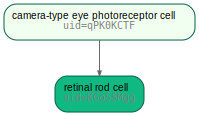

In [20]:
lb.CellType.search('CL:0000604', field="ontology_id",return_queryset=True).first().view_parents()

In [389]:
{lb.Tissue.search(val, field="name",return_queryset=True).first().ontology_id: val for val in ['wall of heart',
'digestive tract epithelium',
'gray matter',
'gyrus',
'lobe of lung',
'blood vessel',
'bone element',]}

{'UBERON:0037144': 'wall of heart',
 'UBERON:0003929': 'digestive tract epithelium',
 'UBERON:0002020': 'gray matter',
 'UBERON:0000200': 'gyrus',
 'UBERON:0000101': 'lobe of lung',
 'UBERON:0001981': 'blood vessel',
 'UBERON:0001474': 'bone element'}

In [ ]:
additional_tissues = {'UBERON:0037144': 'wall of heart',
 'UBERON:0003929': 'digestive tract epithelium',
 'UBERON:0002020': 'gray matter',
 'UBERON:0000200': 'gyrus',
 'UBERON:0000101': 'lobe of lung',
 'UBERON:0001981': 'blood vessel',
 'UBERON:0001474': 'bone element'}


additional_diseases = {'MONDO:0001106': 'kidney failure',
 'MONDO:0021166': 'inflammatory disease',
 'MONDO:0004992': 'cancer',
 'MONDO:0004994': 'cardiomyopathy',
 'MONDO:0700065': 'trisomy',
 'MONDO:0021042': 'glioma',
 'MONDO:0005265': 'inflammatory bowel disease',
 'MONDO:0005550': 'infectious disease',
 'MONDO:0005059': 'leukemia'}

In [131]:
genes.validate(adata.var.index, field="ensembl_gene_id").all()

✅ 26714 terms (99.80%) are validated
❗ 65 terms (0.20%) are not validated: ENSG00000239467, ENSG00000236886, ENSG00000224739, ENSG00000237133, ENSG00000227902, ENSG00000259820, ENSG00000226377, ENSG00000237838, ENSG00000262668, ENSG00000272040, ENSG00000182230, ENSG00000228139, ENSG00000215271, ENSG00000226380, ENSG00000256618, ENSG00000256045, ENSG00000270188, ENSG00000269028, ENSG00000270394, ENSG00000271043, ...


False

## complete
- missing elements already (look at full cellxgene dataset)
- add supergroups that will make things easier if they are there (i.e.
leafs are likely too similar)
- add these higher annotations to cells that have the too similar ones
as well
- replace some too basic ones by "unknown'

In [3]:
import cellxgene_census
import tiledbsoma as soma

census = cellxgene_census.open_soma(census_version = "latest")
batch = ['self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'dataset_id']
features = ['tissue_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id']
df = census["census_data"]["homo_sapiens"].obs.read(column_names=batch+features, value_filter="is_primary_data == True").concat().to_pandas()
df2 = census["census_data"]["mus_musculus"].obs.read(column_names=batch+features, value_filter="is_primary_data == True").concat().to_pandas()
df.shape

(39037801, 9)

In [137]:
Ethnicity.validate(df.rename(columns={'self_reported_ethnicity_ontology_term_id':{'multiethnic':'unknown'}, '':{}}).unique(), field="ontology_id")

✅ 28 terms (93.30%) are validated
❗ 2 terms (6.70%) are not validated: unknown, multiethnic


array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True])

In [176]:
ExperimentalFactor.validate(df['assay_ontology_term_id'].unique(), field="ontology_id").all()

✅ 19 terms (95.00%) are validated
❗ 1 term (5.00%) is not validated: EFO:0700016


False

In [175]:
Disease.validate(df['disease_ontology_term_id'].unique(), field="ontology_id").all()

✅ 71 terms (98.60%) are validated
❗ 1 term (1.40%) is not validated: PATO:0000461


False

In [174]:
DevelopmentalStage.validate(df['development_stage_ontology_term_id'].unique(), field="ontology_id").all()

✅ 171 terms (99.40%) are validated
❗ 1 term (0.60%) is not validated: unknown


False

In [172]:
Tissue.validate(df['tissue_ontology_term_id'].unique(), field="ontology_id").all()

✅ 232 terms (100.00%) are validated


True

In [173]:
celltypes.validate(df['cell_type_ontology_term_id'].unique(), field="ontology_id").all()

✅ 628 terms (100.00%) are validated


True

## dataset management

In [9]:
cx_dataset = ln.Collection.using("laminlabs/cellxgene-census").one()
cx_dataset


Dataset(uid='EAUF1AaT4kOVyHYnZsUJ', name='cellxgene-census', version='2023-07-25', hash='pEJ9uvIeTLvHkZW2TBT5', visibility=0, updated_at=2023-10-24 16:00:07 UTC, transform_id=1, run_id=9, created_by_id=2)

In [10]:
ln.setup.settings.storage.cache_dir = ln.UPath('/home/ml4ig1/.cache/lamindb')

In [11]:
ln.settings.storage

PosixUPath('/home/ml4ig1/Documents code/data2')

In [12]:
storage = ln.Storage(root=ln.settings.storage)

In [13]:
storage.save()

IntegrityError: UNIQUE constraint failed: lnschema_core_storage.root

In [19]:
cx_dataset.files

<django.db.models.fields.related_descriptors.create_forward_many_to_many_manager.<locals>.ManyRelatedManager at 0x7f4da11e61d0>

In [14]:
from django.db import IntegrityError

In [177]:
for file in cx_dataset.files.all()[:10]:
    file.storage = storage
    file.save()

❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`


ValueError: Cannot assign "Storage(uid='HIuhQCHA', root=/home/ml4ig1/Documents code/data2, type='', updated_at=2023-11-19 14:49:24 UTC, created_by_id=1)": the current database router prevents this relation.

In [23]:
localpath = []
for file in cx_dataset.files.all()[:10]:
    #file.storage 
    localpath.append(file.stage())
    try:
        file.save()
    except IntegrityError:
        print(f"File {file.uid} already exists in storage")

NameError: name 'cx_dataset' is not defined

In [14]:
localpath.pop(1)

PosixUPath('/home/ml4ig1/.cache/lamindb/cellxgene-data-public/cell-census/2023-07-25/h5ads/1075c26e-5c47-43ba-902c-5b6cb864dd10.h5ad')

In [11]:
localpath.pop(2)

PosixUPath('/home/ml4ig1/.cache/lamindb/cellxgene-data-public/cell-census/2023-07-25/h5ads/cd3c693e-64e1-4009-a941-ba3f340c7434.h5ad')

In [201]:
path = "/home/ml4ig1/scprint/cell-census/2023-07-25/h5ads/d5c67a4e-a8d9-456d-a273-fa01adb1b308.h5ad"
adata = ad.read_h5ad(path, backed=True)

In [25]:
ad.read_h5ad(val.path, backed=True)

NameError: name 'val' is not defined

In [17]:
list_adata = {}
for i, val in enumerate(localpath):
    adata_ = ad.read_h5ad(val.path, backed=True) 
    dataset_id = cx_dataset.files.all()[i].uid
    adata_.obs['dataset_id'] = dataset_id
    adata_.obs['dataset_id'] = adata_.obs['dataset_id'].astype('category')
    list_adata[dataset_id] = adata_

❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linked, consider passing a `run` or calling ln.track()
💡 you can auto-track this file as a run input by calling `ln.track()`
❗ no run & transform get linke

In [106]:
fullad = ad.experimental.AnnCollection(list_adata, join_vars='inner')

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/experimental/multi_files/_anncollection.py:730: UserWarning: Observation names are not unique.
  warnings.warn("Observation names are not unique.", UserWarning)


In [138]:
list_adata[0].obs

,n_genes,n_counts,percent_mito,donor_id,assay_ontology_term_id,cell_type_ontology_term_id,development_stage_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,is_primary_data,...,author_cell_type,suspension_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
index,,,,,,,,,,,,,,,,,,,,,
0024369980fd003553cbc9dfe29f7f95,2351,6060,4.125412,Donor2,EFO:0009899,CL:0000604,HsapDv:0000136,PATO:0000461,unknown,True,...,retinal rod cell type A,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
002f621cb1c922521e488d9cbf8b707d,5868,28695,3.896149,Donor2,EFO:0009899,CL:0000003,HsapDv:0000136,PATO:0000461,unknown,True,...,unannotated,cell,native cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
0037f1b36684cb59b84d3585ca55ff69,950,1507,0.597213,Donor3,EFO:0009899,CL:0000604,HsapDv:0000147,PATO:0000461,unknown,True,...,retinal rod cell type B,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,female,retina,unknown,53-year-old human stage
00390952646f52d11a9ab9bba7d6ac51,961,1962,7.543323,Donor2,EFO:0009899,CL:0000604,HsapDv:0000136,PATO:0000461,unknown,True,...,retinal rod cell type A,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
005b3351658380695a5dc46c384d72d7,858,1384,0.144509,Donor2,EFO:0009899,CL:0000604,HsapDv:0000136,PATO:0000461,unknown,True,...,retinal rod cell type B,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffa4633bef82949d2c6ac17b3ddf46e9,1813,4129,3.996125,Donor2,EFO:0009899,CL:0000604,HsapDv:0000136,PATO:0000461,unknown,True,...,retinal rod cell type A,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
ffa5758b0600f47722fdc755444dfe0c,2692,8244,16.460457,Donor2,EFO:0009899,CL:0000573,HsapDv:0000136,PATO:0000461,unknown,True,...,retinal cone cell,cell,retinal cone cell,10x 3' v2,normal,Homo sapiens,male,retina,unknown,42-year-old human stage
ffd3fd6119de767f3c3b8c47b2c28bf0,516,896,3.794643,Donor3,EFO:0009899,CL:0000604,HsapDv:0000147,PATO:0000461,unknown,True,...,retinal rod cell type A,cell,retinal rod cell,10x 3' v2,normal,Homo sapiens,female,retina,unknown,53-year-old human stage


In [103]:
fullad.var_names

Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000000938', 'ENSG00000000971',
       'ENSG00000001036', 'ENSG00000001084', 'ENSG00000001167',
       'ENSG00000001460',
       ...
       'ENSG00000273416', 'ENSG00000273437', 'ENSG00000273448',
       'ENSG00000273449', 'ENSG00000273456', 'ENSG00000273464',
       'ENSG00000273473', 'ENSG00000273474', 'ENSG00000273486',
       'ENSG00000273489'],
      dtype='object', length=15335)

In [20]:
k = "CAQPyYbcP4UjgiIfniQK"

In [21]:
adata = list_adata[k]

In [30]:
unseen = {}

In [58]:
adata = adata.to_memory()

In [131]:
from scprint2.dataset.preprocess import Preprocessor
%reload_ext autoreload
%autoreload 2

In [105]:
k = "test"

In [144]:
def preproc(adata):
    adata.obs = adata.obs.replace({'self_reported_ethnicity_ontology_term_id':{
        'multiethnic':'unknown',
        'American':'unknown',
        'Jewish Israeli': 'unknown',
        'na': 'unknown'}}) #multi ethnic will have to get renamed
    return adata

In [202]:
preprocess = Preprocessor(lb, additional_preprocess=preproc)

In [187]:
add = ["CL:0000648", "CL:0019018"]
records = lb.CellType.from_values(add, field=lb.CellType.ontology_id)
ln.save(records)

❗ now recursing through parents: this only happens once, but is much slower than bulk saving


In [190]:
add = ["EFO:0030062"]
records = lb.ExperimentalFactor.from_values(add, field=lb.ExperimentalFactor.ontology_id)
ln.save(records)

❗ now recursing through parents: this only happens once, but is much slower than bulk saving


In [203]:
adata = preprocess(adata)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


Removed 90 genes.

Seeing 4154 outliers (21.09% of total dataset):


In [230]:
len(list(unseen.tolist()))

33079

In [231]:
adata.uns['unseen_genes'] = list(unseen.tolist())

In [232]:
adata.write_h5ad("test.h5ad")

In [3]:
adata = ad.read_h5ad("test.h5ad")

In [7]:
import scanpy as sc

In [8]:
sc.tl.diffmap(adata)

In [77]:
# define the "up to" 10 neighbors for each cells and add to obs
    # compute neighbors
    # need to be connectivities and same labels [cell type, assay, dataset, disease]
# define the "next time point" up to 5(M) cells and add to obs  

In [10]:
adata.obs['heat'] = adata.obsm["X_diffmap"][:, 0]

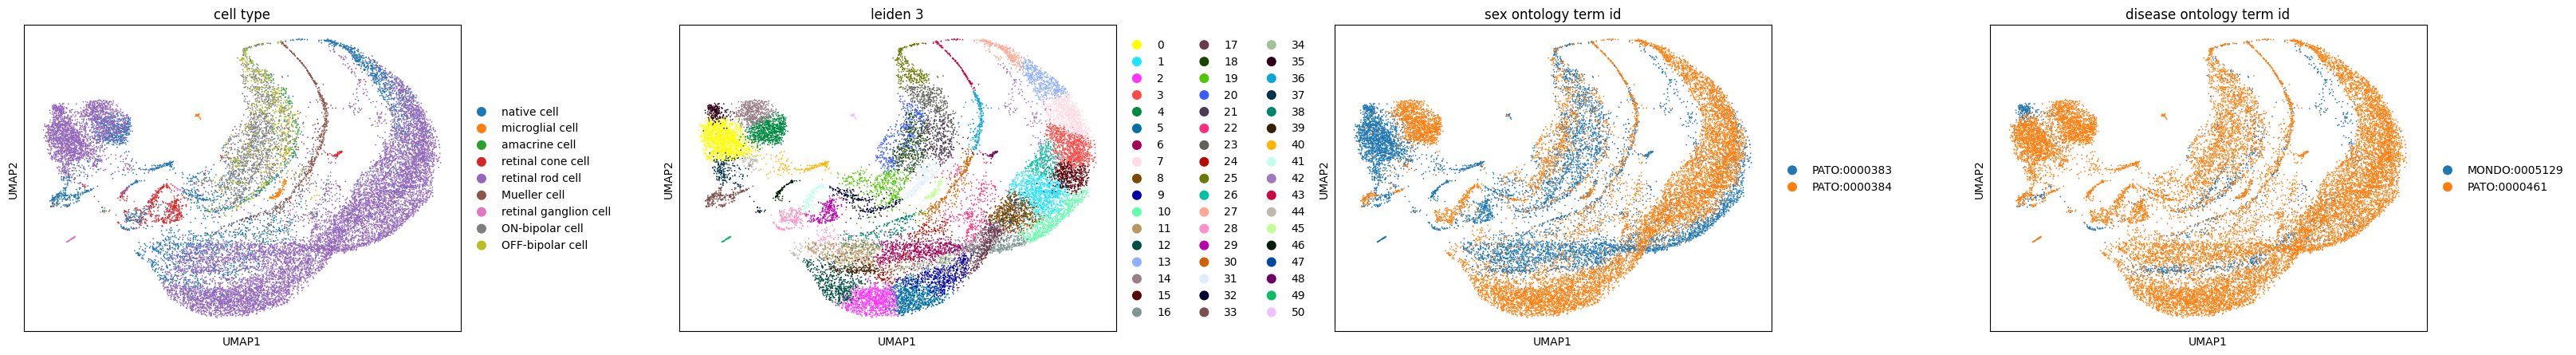

In [13]:
sc.pl.scatter(adata, basis="umap", color=['cell_type', 'leiden_3', 'sex_ontology_term_id', "disease_ontology_term_id"])

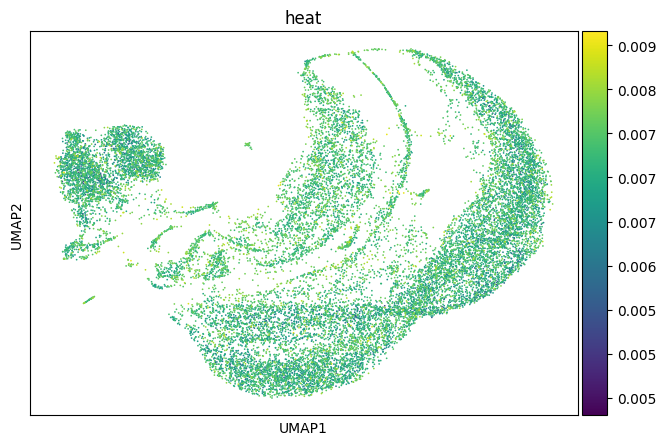

In [14]:
sc.pl.scatter(adata, basis="umap", color=["heat"])

## for all cells create the 5 next time point cells

per cluster + disease + cell type + tissue +

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
... storing 'dpt_group' as categorical


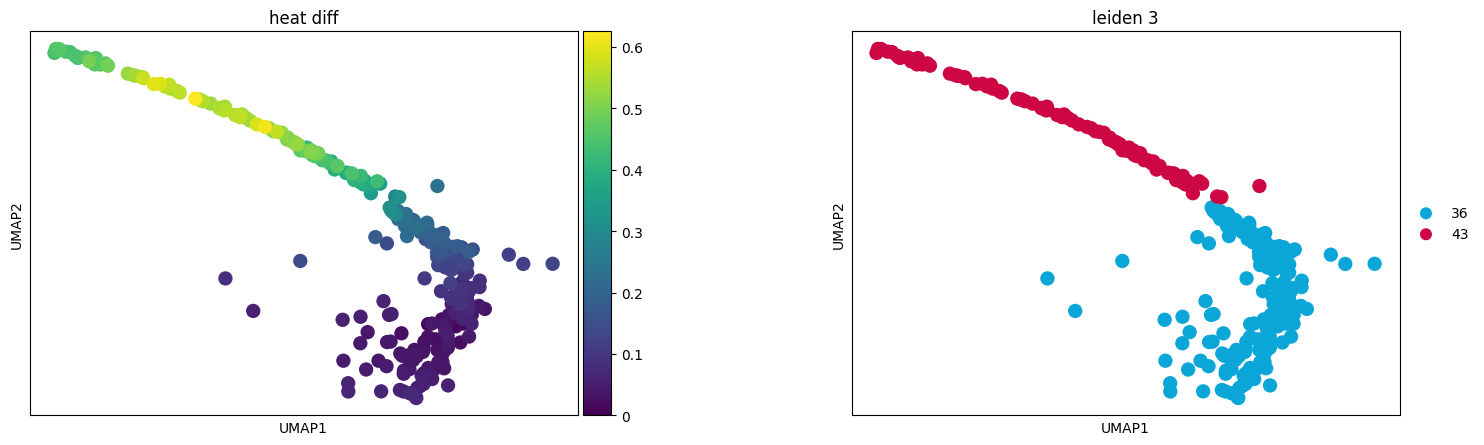

In [23]:
sc.pl.scatter(adata[eq], basis="umap", color=["heat_diff", "leiden_3"])

In [41]:
adata.obs['heat_diff']

index
0024369980fd003553cbc9dfe29f7f95    0.015115
002f621cb1c922521e488d9cbf8b707d    0.016923
0037f1b36684cb59b84d3585ca55ff69    0.034581
00390952646f52d11a9ab9bba7d6ac51    0.043176
005b3351658380695a5dc46c384d72d7    0.018042
                                      ...   
ffa4633bef82949d2c6ac17b3ddf46e9    0.071882
ffa5758b0600f47722fdc755444dfe0c    0.033949
ffd3fd6119de767f3c3b8c47b2c28bf0    0.020480
ffe21ae45a7fad28db64783d0697fc4f    0.033010
fffd3d11e75c6c544e6741967b3edb7a    0.044117
Name: heat_diff, Length: 19694, dtype: float64

In [46]:
adata.obs['plot_heat_diff'] = [0.2 if i > 0.2 else i for i in adata.obs['heat_diff']]

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


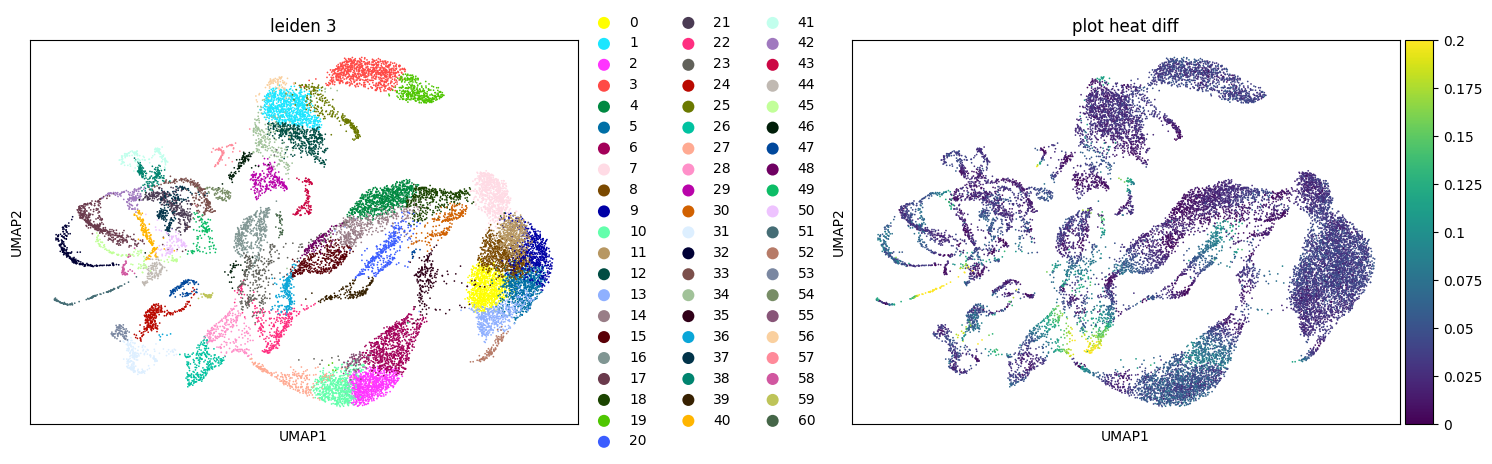

In [47]:
sc.pl.scatter(adata, basis="umap", color=["leiden_3", "plot_heat_diff"])

In [115]:
# create a meta group
adata.obs['dpt_group'] = adata.obs['leiden_1'].astype(str) + "_" + adata.obs['disease_ontology_term_id'].astype(str) + "_" + adata.obs['cell_type_ontology_term_id'].astype(str) + "_" + adata.obs['tissue_ontology_term_id'].astype(str) #+ "_" + adata.obs['dataset_id'].astype(str)

# if group is too small
okgroup = [i for i, j in adata.obs['dpt_group'].value_counts().items() if j>=10]
not_okgroup = [i for i, j in adata.obs['dpt_group'].value_counts().items() if j<3]
# set the group to empty
adata.obs.loc[adata.obs['dpt_group'].isin(not_okgroup), 'dpt_group'] = ''
adata.obs['heat_diff'] = np.nan
# for each group
for val in set(okgroup):
    if val == '':
        continue
    # get the best root cell
    eq = adata.obs.dpt_group==val
    loc = np.where(eq)[0]

    root_ixs = loc[adata.obsm["X_diffmap"][eq, 0].argmin()]
    adata.uns["iroot"] = root_ixs
    # compute the diffusion pseudo time from it
    sc.tl.dpt(adata)
    adata.obs.loc[eq, 'heat_diff'] = adata.obs.loc[eq, 'dpt_pseudotime']
    adata.obs.drop(columns=['dpt_pseudotime'], inplace=True)

#sort so that the next time points are aligned for all groups
adata = adata[adata.obs.sort_values(['dpt_group','heat_diff']).index]
#to query N next time points we just get the N elements below and check they are in the group
# to query the N nearest neighbors we just get the N elements above and N below and check they are in the group

TypeError: object of type 'int' has no len()

In [114]:
# TODO: store it as an awkward array obsm in the anndata or as a sparse array like connectivities

In [ ]:
from scipy.sparse import find

/tmp/ipykernel_195385/1863125994.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.31533626 0.56458086 1.         0.89212644 0.0899928  0.10647792
 1.         0.22093962 0.2369727  0.33846393 0.03702245 0.12825827
 0.12653698 0.39368445 0.43781158]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.iloc[find(adata.obsp['connectivities'][LOC])[1].tolist(),-1] = find(adata.obsp['connectivities'][LOC])[2]
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


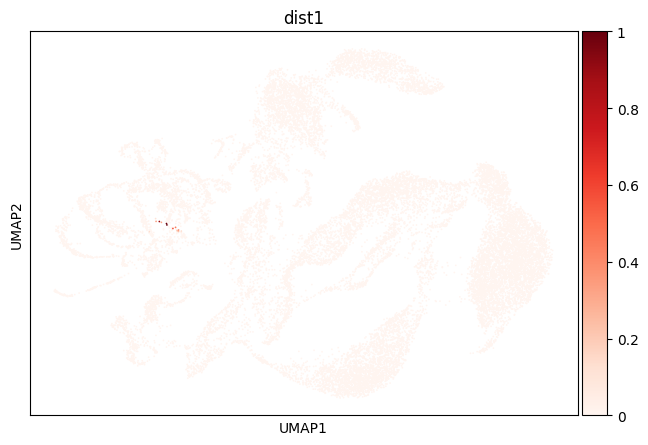

In [107]:
LOC = 1050
adata.obs['dist1'] = 0
adata.obs.iloc[find(adata.obsp['connectivities'][LOC])[1].tolist(),-1] = find(adata.obsp['connectivities'][LOC])[2]
sc.pl.scatter(adata, basis="umap", color=["dist1"], color_map="Reds")


## find the up to 10 nearest neighboors

In [48]:
# getting the top 10 neighbors
ids = np.zeros((adata.shape[0], 10), dtype=int)-1
for i in range(adata.shape[0]):
    _, loc, val = find(adata.obsp['connectivities'][i])
    loc = loc[val.argsort()[:10]]
    ids[i, :len(loc)] = loc

AnnData object with n_obs × n_vars = 19694 × 70116
    obs: 'n_genes', 'n_counts', 'percent_mito', 'donor_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'dataset_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leiden_2', 'leiden_1', 'dpt_group', 'heat_diff', 'plot_heat_diff'
    var: 'chromosome', 'featureend', 'feature

## putting it all together

In [71]:
MINDATASET_SIZE = 100
MIN_VALID_GENES_ID = 10_000
MIN_NNZ_GENES = 300
MIN_NNZ_GENES_SLIDESEQ = 100
MAXDROPAMOUNT = 2 # 1/[2] = 50% of the dataset
MAX_NEIGHBORS = 10
DO_NORM=True
MADOUTLIER = 5
PCT_MT_OUTLIER = 8
FULL_LENGTH_ASSAYS = ['EFO: 0700016', 'EFO:0008930', 'EFO:0008931',]

In [130]:
lb.Gene.filter(symbol="TSPAN6").one()

Gene(uid='mRzSiS7BgReH', symbol='TSPAN6', ensembl_gene_id='ENSG00000000003', ncbi_gene_ids='7105', biotype='protein_coding', description='tetraspanin 6 [Source:HGNC Symbol;Acc:HGNC:11858]', synonyms='T245|TSPAN-6|TM4SF6', updated_at=2023-11-22 13:16:56 UTC, organism_id=2, bionty_source_id=9, created_by_id=1)

In [119]:
adata.obsm['X_spatial']

ArrayView([[2911.90625   , 4155.71875   ],
           [1733.28409091, 1766.56818182],
           [2351.80246914, 4196.20987654],
           ...,
           [4379.85882353, 3694.90588235],
           [2911.05442177, 2520.72789116],
           [3645.14285714,  817.55357143]])

In [37]:
genesdf = lb.Gene.df()
genesdf = genesdf.drop_duplicates(subset='ensembl_gene_id')
genesdf = genesdf.set_index('ensembl_gene_id')
# mitochondrial genes
genesdf["mt"] = genesdf.symbol.astype(str).str.startswith("MT-")
# ribosomal genes
genesdf["ribo"] = genesdf.symbol.astype(str).str.startswith(("RPS", "RPL"))
# hemoglobin genes.
genesdf["hb"] = genesdf.symbol.astype(str).str.contains(("^HB[^(P)]"))

In [105]:
cx_datasets['size'].sum()/1_000_000_000

NameError: name 'cx_datasets' is not defined